# 🐢 Turtles sightings 🐢
This notebooks illustrates the computation of a heatmap using observation locations. 

Dataset: Marine Turtles	National Biodiversity Network Trust. Marine Turtles. National Biodiversity Network Trust, Newark, UK.      
https://doi.org/10.15468/fyt9hw,       
https://portal.obis.org/dataset/1cfc4d23-9fcd-42b2-95bf-9c4ee9bc50f6

### IMPORTANT: this can take some time to execute...

In [5]:
using Pkg
Pkg.develop(PackageSpec(path="/home/ctroupin/ULiege/Tools/divand.jl"))

 Resolving package versions...
  Updating `~/Projects/Diva-Workshops/Project.toml`
 [no changes]
  Updating `~/Projects/Diva-Workshops/Manifest.toml`
 [no changes]


In [6]:
using DIVAnd
using PyPlot
#using NCDatasets
#using DataStructures
using Statistics
using DelimitedFiles
using LinearAlgebra
using Random

In [7]:
DIVAnd.DIVAnd_

UndefVarError: UndefVarError: DIVAnd_ not defined

In [2]:
# Read the data retrieved from OBIS
turtlefile = "../data/turtles.dat"
if !isfile(turtlefile)
    download("https://dox.ulg.ac.be/index.php/s/IsWWlNxWeQDuarJ", turtlefile)
end
AA=readdlm(turtlefile)
@show size(AA);

size(AA) = (2494, 2)


In [3]:
lon=AA[:,1]
lat=AA[:,2]
mean(lon), mean(lat)

(-6.812426180783882, 52.77852833638372)

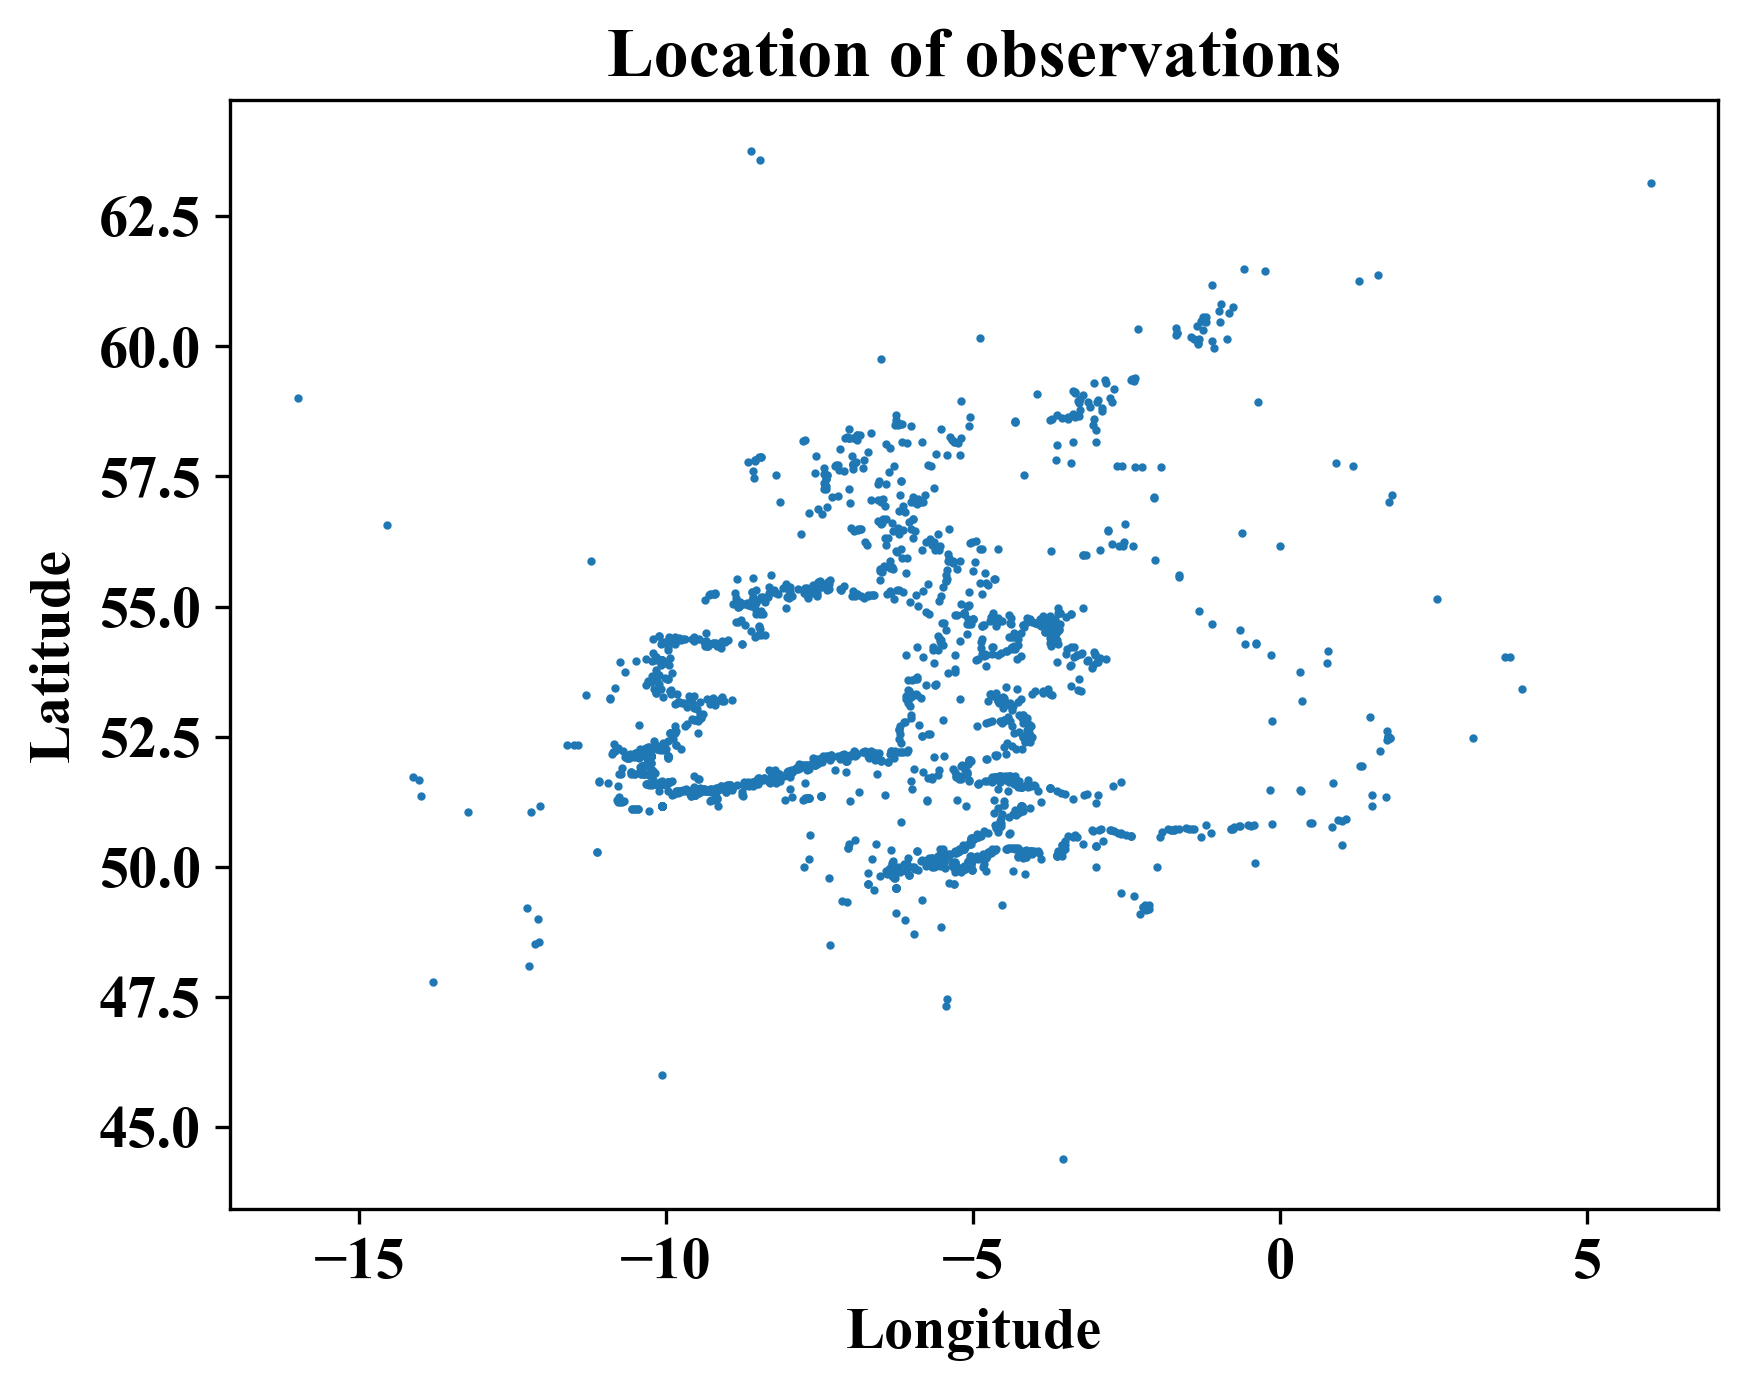

PyObject Text(0.5, 1.0, 'Location of observations')

In [4]:
scatter(lon,lat,s=1)
xlabel("Longitude")
ylabel("Latitude")
title("Location of observations")

## A simple heatmap without land mask

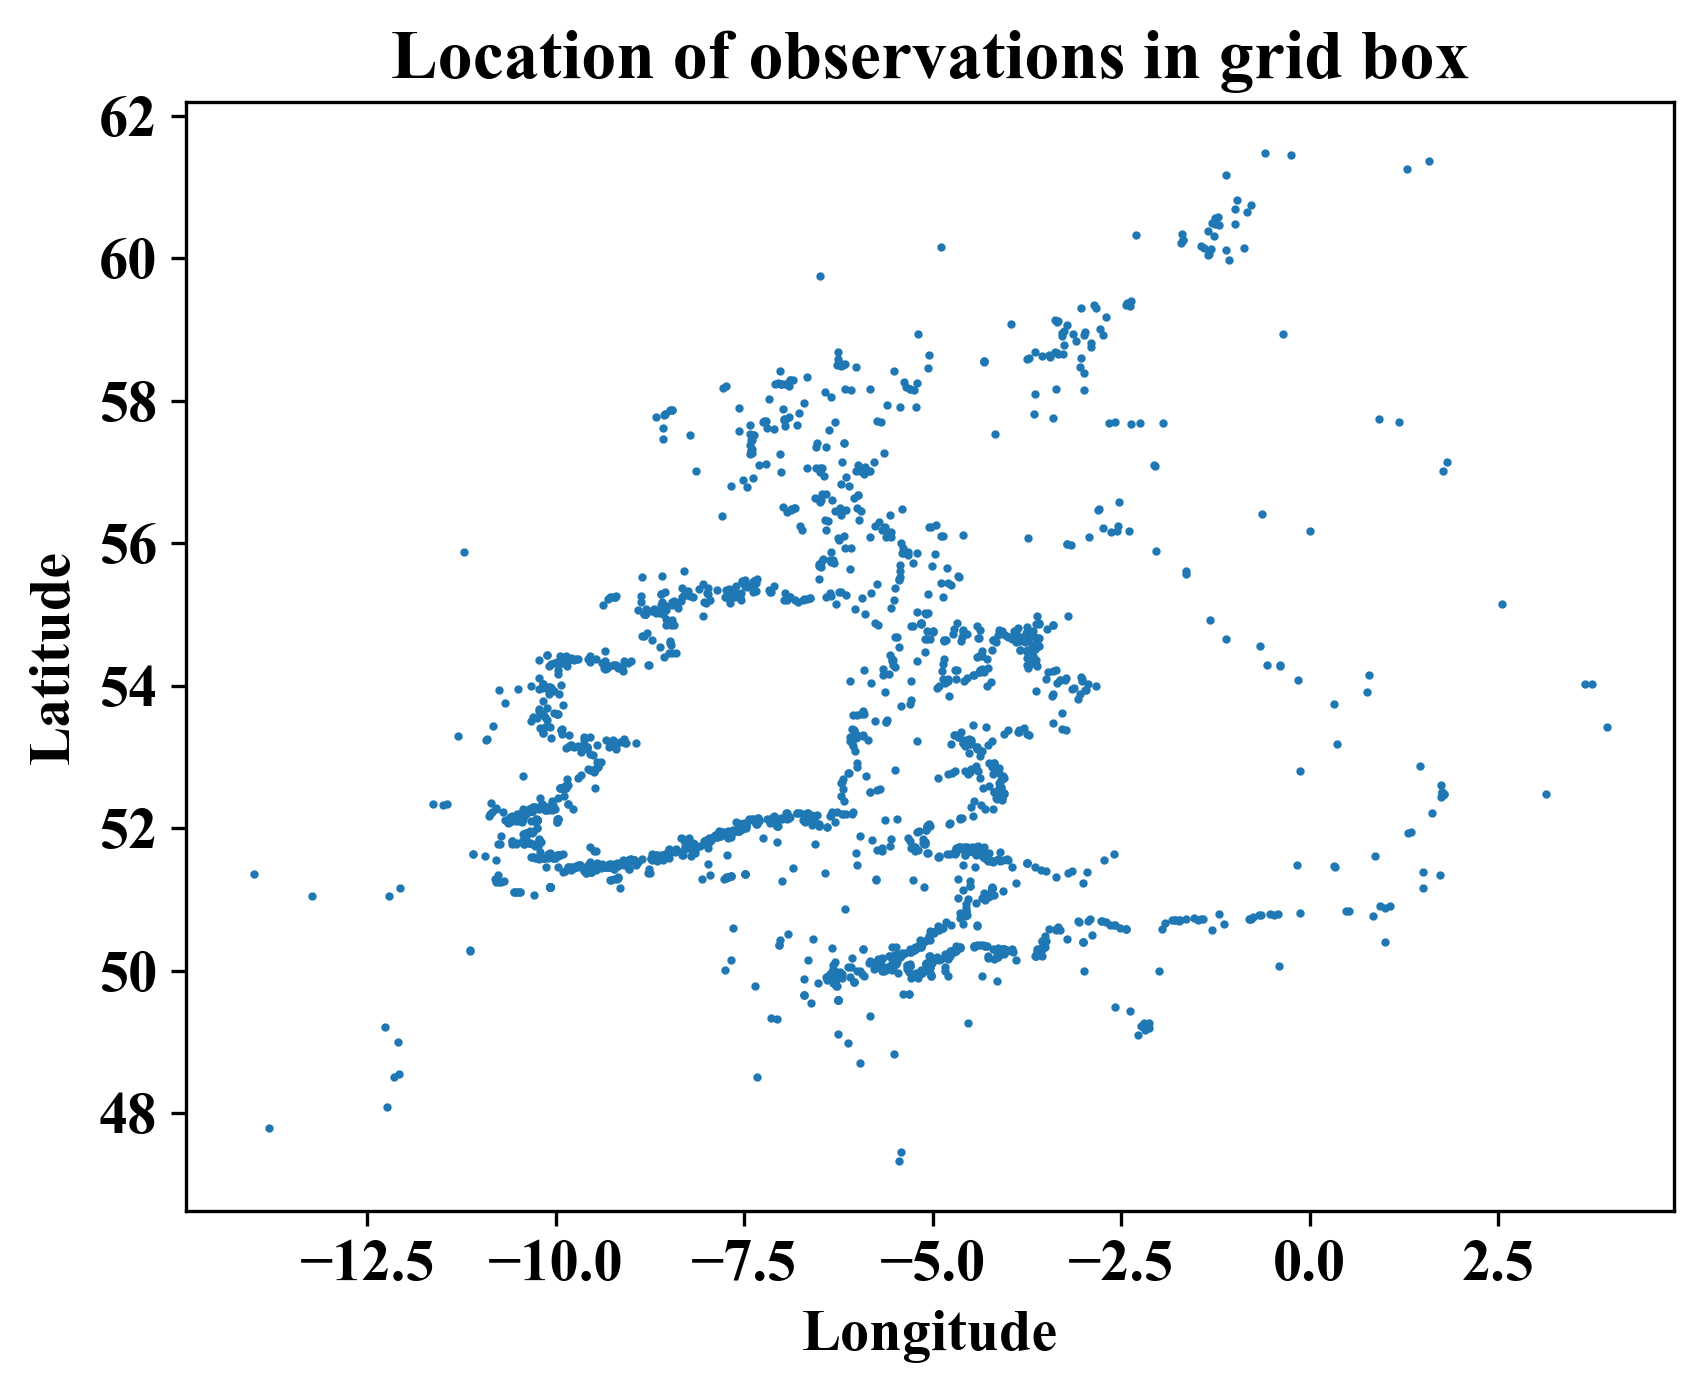

PyObject Text(0.5, 1.0, 'Location of observations in grid box')

In [5]:
NX=300
NY=250
# Box size
LX=18.
LY=15.
# Bounding box
xleft=-14.
ybot=47.
xright=xleft+LX
ytop=ybot+LY

xo=lon
yo=lat

# Eliminate points out of the box
sel=(xo.>xleft) .& (xo.<xright) .& (yo.>ybot) .& (yo.<ytop)

xo=xo[sel]
yo=yo[sel]
inflation=ones(size(xo))
scatter(xo,yo,s=1)
xlabel("Longitude")
ylabel("Latitude")
title("Location of observations in grid box")

### Heatmap

In [6]:
dx=LX/(NX)
dy=LY/(NY)

xg = xleft+dx/2:dx:xleft+LX
yg = ybot+dy/2:dy:ybot+LY
# for pyplot
xp=xleft:dx:xleft+LX
yp = ybot:dy:ybot+LY
maskp,(pmp,pnp),(xip,yip) = DIVAnd.DIVAnd_rectdom(xp,yp)

mask,(pm,pn),(xi,yi) = DIVAnd.DIVAnd_rectdom(xg,yg)


# adding a mask
#mask[(xi.+0.25)./0.95 .+ (yi.-2.4)./1.1 .<1 ].=false
#mask[2*xi.+yi .<3.4 ].=false

@show size(xi)
# From here generic approach 
@time dens1,LHM,LCV,LSCV = DIVAnd.DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=1)

figure()
pcolor(xip,yip,dens1),colorbar()
scatter(xo,yo,s=1,c="white")
xlabel("Longitude")
ylabel("Latitude")
title("Density and observations")
@show LCV,LSCV,mean(LHM[1]),mean(LHM[2])

size(xi) = (300, 250)


UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [7]:
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("Density (log)")

UndefVarError: UndefVarError: dens1 not defined

## Now prepare land mask

In [8]:
bathname = "../data/gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[8]:6


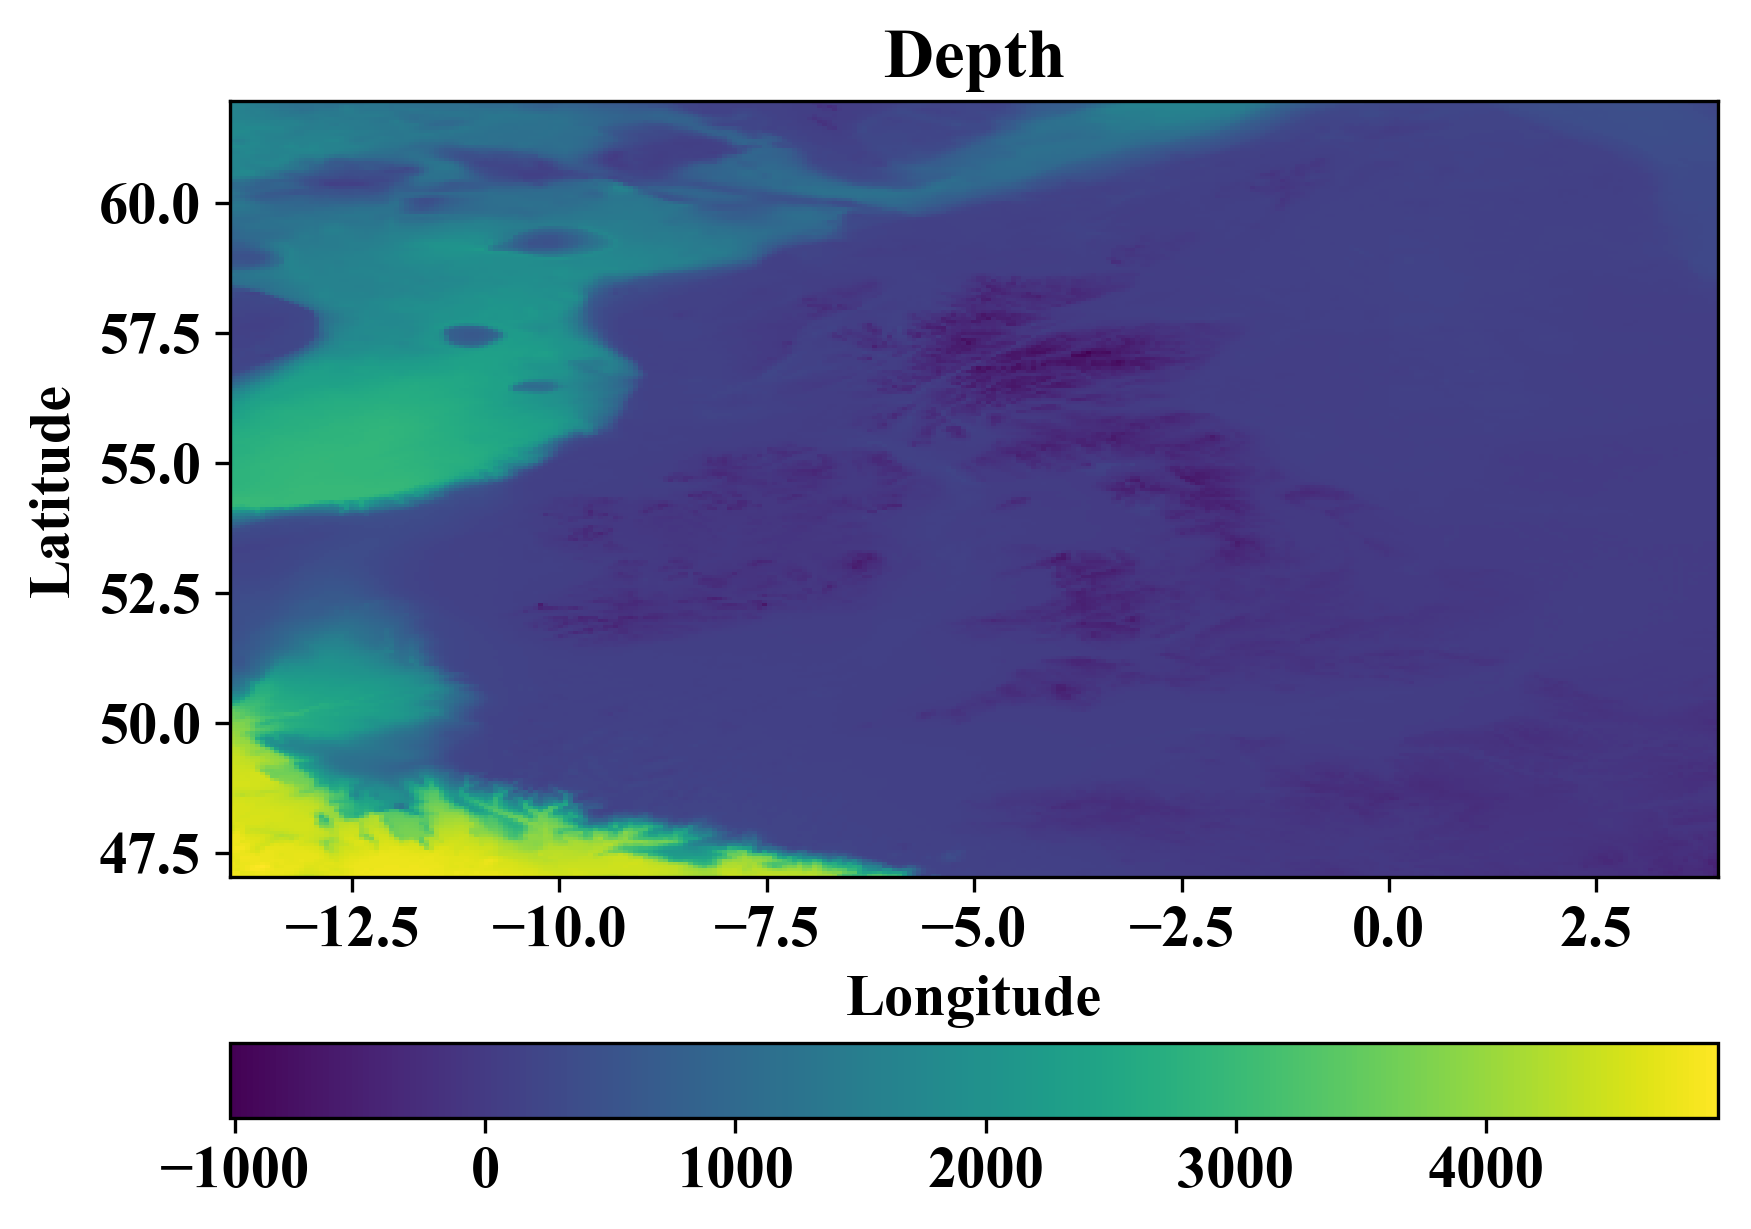

size(b) = (300, 250)


(300, 250)

In [9]:
bx,by,b = load_bath(bathname,true,xg,yg)

pcolor(bx,by,b'); colorbar(orientation="horizontal")
xlabel("Longitude")
ylabel("Latitude")
title("Depth")

@show size(b)

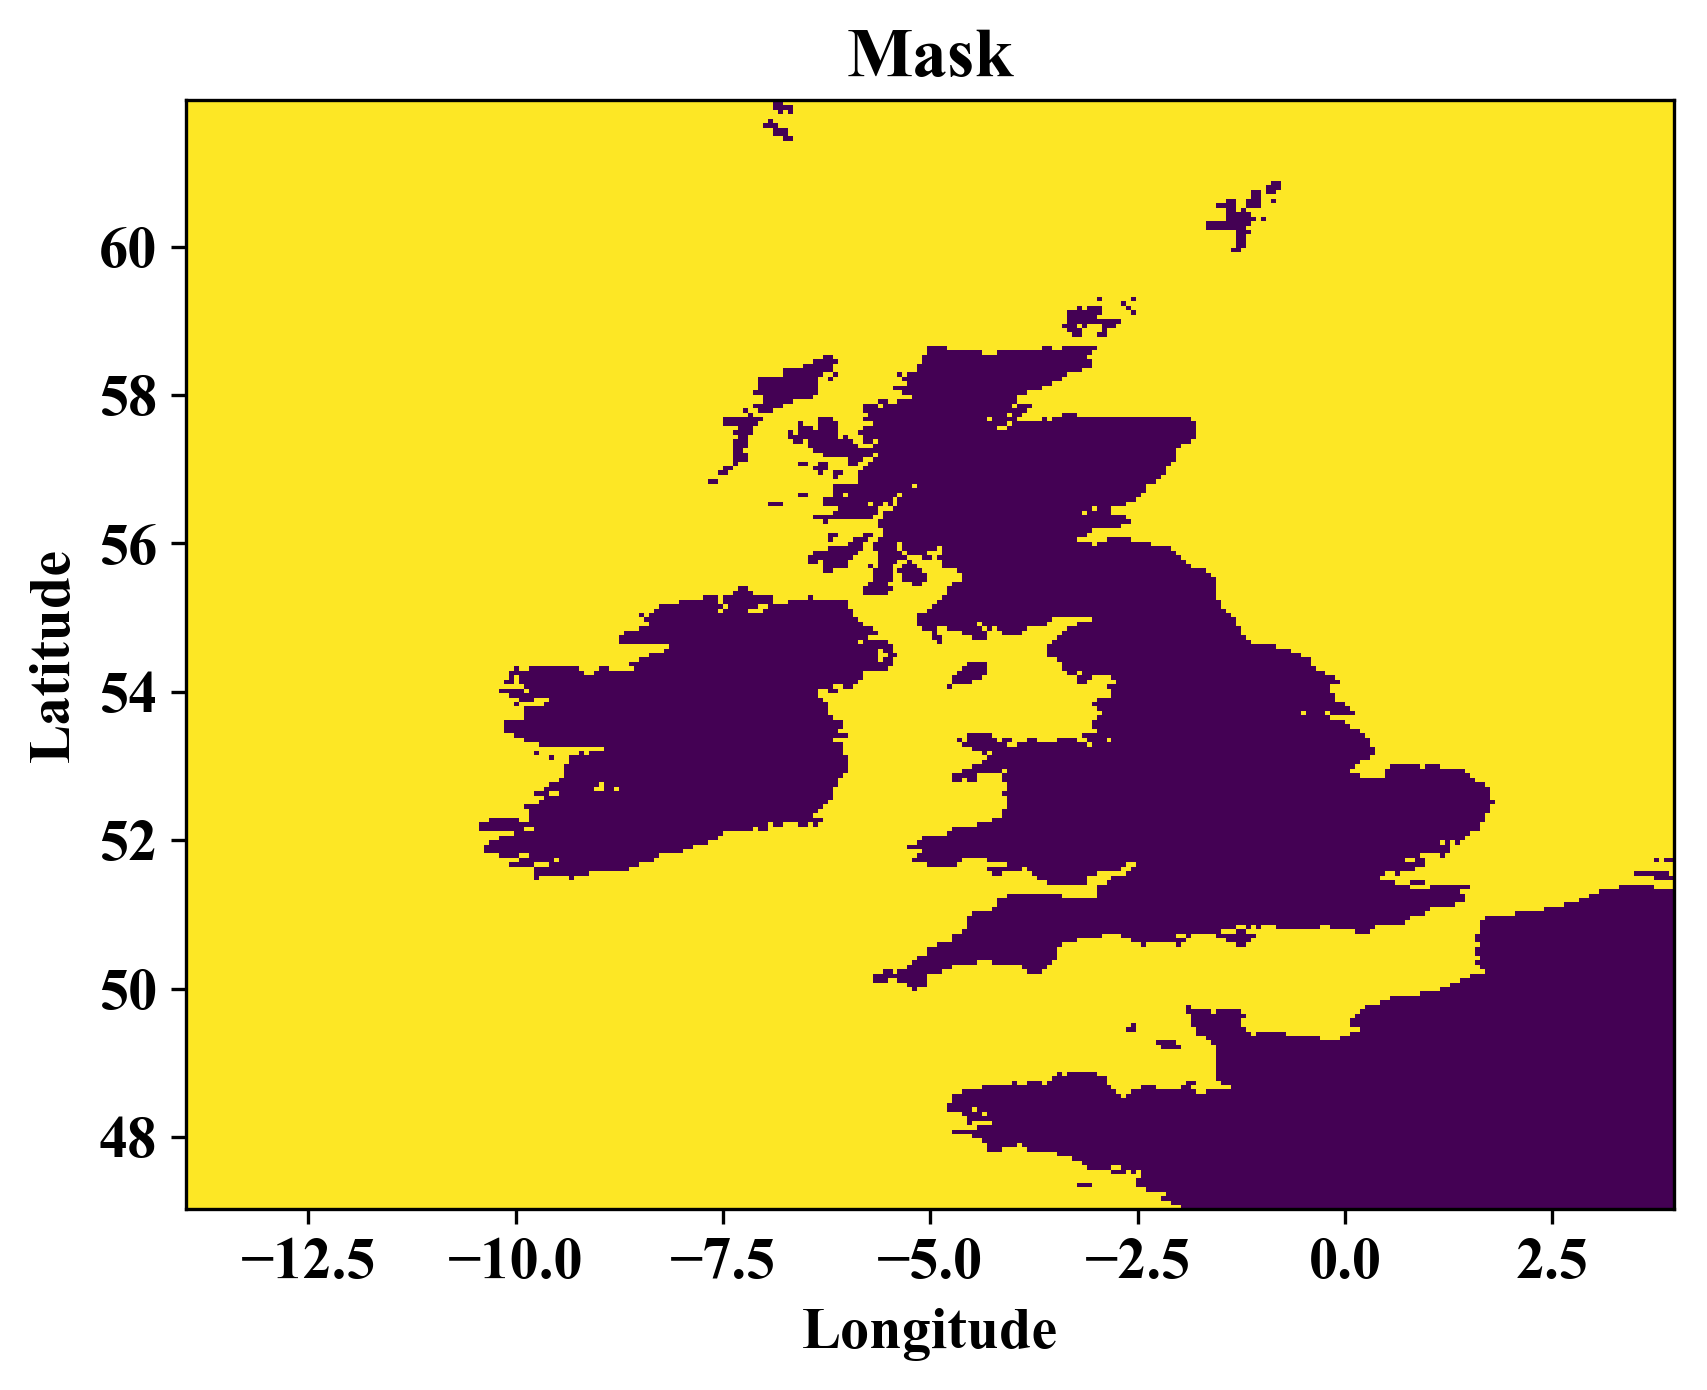

PyObject Text(0.5, 1.0, 'Mask')

In [10]:
for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >= 0
    end
end
pcolor(bx,by,Float64.(mask)')
xlabel("Longitude")
ylabel("Latitude")
title("Mask")

### First heatmap with uniform and automatic bandwidth

In [11]:
@time dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=0)

figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
#scatter(xo,yo,s=1,c="white")
title("Density (log)")
@show LCV,LSCV,mean(LHM[1]),mean(LHM[2])

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

## Now with adapted bandwidth

In [12]:
@time dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=1)

figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
#scatter(xo,yo,s=1,c="white")
title("Density (log)")


@show LCV,LSCV,mean(LHM[1]),mean(LHM[2])

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

### But how much iterations ? Cross validation indicators can help 

In [13]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=0)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [14]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=1)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [15]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=2)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [16]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=3)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [17]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=4)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [18]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=5)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

## 4 iterations yield highest likelyhood and lowest rms

In [19]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=4)
figure()
pcolor(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

UndefVarError: UndefVarError: DIVAnd_heatmap not defined

In [20]:
pcolor(xip,yip,log.(LHM[1].*LHM[2])),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("Surface of bandwidth (log)")

UndefVarError: UndefVarError: LHM not defined

# Important note

There is no information used on the effort of looking for turtles. Obviously more are seen close to coastlines because of easier spotting.